In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from transformers import pipeline
import os

import nibabel as nib

def show_middle_slice(nii_path, axis=2):
    # 1. Load the NIfTI file
    img = nib.load(nii_path)
    
    # 2. Get the data as a numpy array
    # get_fdata() ensures the data is returned as floating point numbers
    data = img.get_fdata()
    
    # Check if the file is 4D (e.g., fMRI) and select the first time volume if so
    if len(data.shape) == 4:
        data = data[:, :, :, 0]
    
    # 3. Calculate the middle index for the chosen axis
    # Axis 0 = Sagittal, Axis 1 = Coronal, Axis 2 = Axial (usually)
    mid_index = data.shape[axis] // 2
    
    # 4. Slice the array
    if axis == 0:
        slice_img = data[mid_index, :, :]
    elif axis == 1:
        slice_img = data[:, mid_index, :]
    else: # axis == 2
        slice_img = data[:, :, mid_index]
    
    # 5. Rotate if necessary (Medical images often load rotated 90 deg relative to viewers)
    slice_img = np.rot90(slice_img)
    
    # 6. Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_img, cmap='gray')
    plt.title(f"Middle Slice (Index: {mid_index}) along Axis {axis}")
    plt.axis('off')
    plt.show()

def show_overlay(image_path, mask_path, axis=2):
    """
    Overlays the middle slice of a mask onto the middle slice of a medical image.
    """
    # 1. Load the files
    img_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)
    
    img_data = img_nii.get_fdata()
    mask_data = mask_nii.get_fdata()
    
    # Ensure dimensions match
    if img_data.shape != mask_data.shape:
        print(f"Warning: Dimensions differ. Img: {img_data.shape}, Mask: {mask_data.shape}")
        # You might need to resize if they differ, but usually they match in registered pairs.

    # 2. Select the middle slice index
    mid_index = img_data.shape[axis] // 2
    
    # 3. Slice the data
    if axis == 0:
        img_slice = img_data[mid_index, :, :]
        mask_slice = mask_data[mid_index, :, :]
    elif axis == 1:
        img_slice = img_data[:, mid_index, :]
        mask_slice = mask_data[:, mid_index, :]
    else: # axis == 2 (Axial)
        img_slice = img_data[:, :, mid_index]
        mask_slice = mask_data[:, :, mid_index]
    
    # 4. Rotate for better viewing (optional, consistent with previous step)
    img_slice = np.rot90(img_slice)
    mask_slice = np.rot90(mask_slice)
    
    # 5. Prepare the Mask for Overlay
    # We use numpy to create a "masked array". 
    # This tells matplotlib to ignore pixels where the mask value is 0 (background).
    masked_mask = np.ma.masked_where(mask_slice == 0, mask_slice)

    # 6. Plotting
    plt.figure(figsize=(8, 8))
    
    # First layer: The anatomical image (Gray)
    plt.imshow(img_slice, cmap='gray', interpolation='none')
    
    # Second layer: The mask (Red/Autumn) with transparency
    # 'alpha=0.5' makes it semi-transparent
    plt.imshow(masked_mask, cmap='autumn', alpha=0.5, interpolation='none')
    
    plt.title(f"Overlay at Slice {mid_index} (Axis {axis})")
    plt.axis('off')
    plt.show()

def get_middle_slice_segmentation(image_path, mask_path, axis=2):
    """
    Loads image and mask, extracts the geometric middle slice, 
    and returns a 2D numpy array of the object (background set to 0).
    """
    # 1. Load NIfTI files
    img_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)
    
    img_data = img_nii.get_fdata()
    mask_data = mask_nii.get_fdata()
    
    # Handle 4D data if necessary
    if img_data.ndim == 4:
        img_data = img_data[..., 0]

    # 2. Determine the middle index
    # We use the image shape to find the geometric center of the volume
    mid_index = img_data.shape[axis] // 2
    
    # 3. Slice the Image and the Mask
    if axis == 0:
        slice_img = img_data[mid_index, :, :]
        slice_mask = mask_data[mid_index, :, :]
    elif axis == 1:
        slice_img = img_data[:, mid_index, :]
        slice_mask = mask_data[:, mid_index, :]
    else: # axis == 2
        slice_img = img_data[:, :, mid_index]
        slice_mask = mask_data[:, :, mid_index]
    
    # 4. Apply the mask
    # Create a boolean mask where valid pixels are True
    binary_mask = slice_mask > 0
    
    # Multiply image by mask (Background becomes 0, Object remains original intensity)
    segmented_slice = slice_img * binary_mask
    
    return segmented_slice

def plot_segmented_slice(segmented_slice_data):
    """
    Visualizes the 2D numpy array of the segmented object.
    """
    # 1. Rotate for display (Standard NIfTI orientation fix)
    to_plot = np.rot90(segmented_slice_data)
    
    # 2. Plotting
    plt.figure(figsize=(6, 6))
    
    # We plot using gray. The background (0 values) will appear black.
    plt.imshow(to_plot, cmap='gray')
    
    plt.title("Segmented Object (Middle Slice)")
    plt.axis('off')
    plt.show()



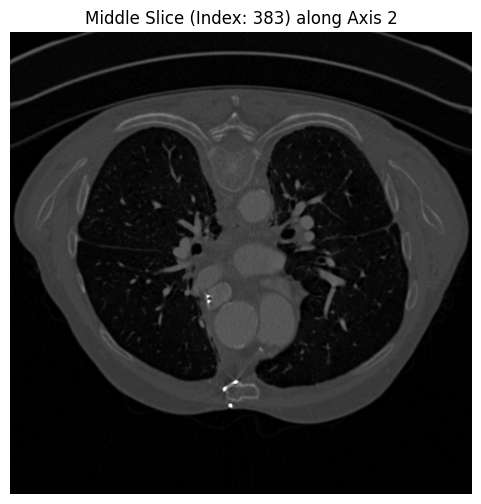

In [2]:
# Usage
# Replace with your file path
file_path = '/PHShome/yl535/project/python/datasets/AeroPath/data/1/1_CT_HR.nii.gz'
# Run the function (try axis=0, 1, or 2 to see different views)
show_middle_slice(file_path, axis=2)

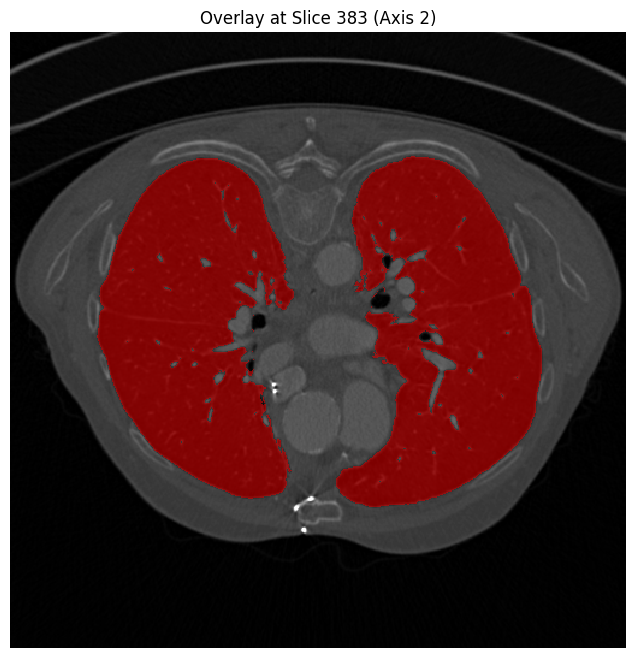

In [6]:
ct_path = '/PHShome/yl535/project/python/datasets/AeroPath/data/1/1_CT_HR.nii.gz'
mask_path = '/PHShome/yl535/project/python/datasets/AeroPath/data/1/1_CT_HR_label_lungs.nii.gz'
show_overlay(ct_path, mask_path, axis=2)

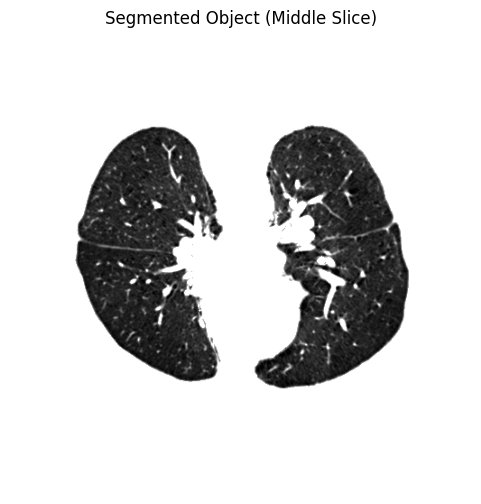

In [ ]:
ct_path = '/PHShome/yl535/project/python/datasets/AeroPath/data/1/1_CT_HR.nii.gz'
mask_path = '/PHShome/yl535/project/python/datasets/AeroPath/data/1/1_CT_HR_label_lungs.nii.gz'

seg_slice = get_middle_slice_segmentation(ct_path, mask_path, axis=2)

plot_segmented_slice(seg_slice)